In [1]:
# basics
import os, sys

# arrays
import numpy as np
import xarray as xr

# multiprocessing
from multiprocessing import Pool

# Object pickling
import dill

# append sscode to path
sys.path.insert(0, '..')

# custom
from sscode.config import (
    default_location,
    default_region,
    default_region_reduced,
    data_path
)
from sscode.data import Loader
from sscode.pca_new import PCA_DynamicPred

# warnings
import warnings
warnings.filterwarnings('ignore')

# for autocomplete code
%config Completer.use_jedi = False

DATA PATH /home/javitausia/Documentos/geocean-nz-ss/data


We start by loading the data

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=(False,False,False),
    load_predictor_files=(True,
        [data_path+'/cfsr/CFSR_MSLP_daily.nc',data_path+'/cfsr/CFSR_WINDs_daily.nc']
    ) # load previously calculated winds
)


 loading previously saved atmospheric data... 


 loading the UHSLC tidal guages... 



The experiments we are about to run all involve running the predictors through a first step of Principal Component Analysis (PCA). The analysis can be quite expensive to run and as we don't want to repeat the operation multiple time we first precompute all PCs and store them on drive.
The following class has been designed to sequentialy run the PCA analysis for all the sets of predictors considers in the experiments. We found that running the analysis on the largest predictor sets required the full amount of the 128 Gb of RAM available on our server. Also, as the PCA function from scikit learn used under the hood is parralelised this sequential approach made full usage of the CPU resources too.

In [3]:
class PCA_PreComputer(object):
    """
    This class allows to compute the principal components for givens sets of predictors and
    store them on drive
    """

    def __init__(self, slp_data,
                 wind_data,
                 ss_data,
                 sites_to_analyze,
                 pca_attrs,
                 pcs_folder):
        """
        As the initializator, the __init__ function creates the instance of the class,
        given a set of parameters, which are described below

        Args:
            slp_data (xarray.Dataset): These are the sea-level-pressure fields, previously
                loaded with the Loader class, loader.predictor_slp!!
            wind_data (xarray.Dataset): These are the wind fields, previously
                loaded with the Loader class, loader.predictor_wind!!
            ss_data (xarray.Dataset): This is the storm surge from the moana hindcast, previously
                loaded with the Loader class, loader.predictand!!
            sites_to_analyze (list, optional): This is the list with all the moana v2
                hindcast locations to analyze. Defaults to random locations.
            pca_attrs (dict, optional): PCA dictionary with all the parameters to use in pca.
                Defaults to pca_attrs_default.
            pcs_folder (string, optionl): The folder from/in which the PCs should be loaded/saved.
        """

        self.slp_data = slp_data
        self.wind_data = wind_data
        self.ss_data = ss_data
        self.ss_sites = sites_to_analyze
        self.pca_attrs = pca_attrs
        self.pcs_folder = pcs_folder
    

    def compute_pcas(self):
        """
        This function goes over all the sites/configurations and computes
        and stores the results of the PCA analysis if not already available       
        """

        for isite,site in enumerate(self.ss_sites):

            # we first load in memmory the selected site
            ss_site = self.ss_data.isel(site=site)[[
                'ss','lat','lon'
            ]].load() # load the ss and the location of the site
            site_location = (ss_site.lon.values,ss_site.lat.values)

            # lets iterate over all the pca_attrs + model_attrs
            counter = 0
            for i_parameters,parameters in zip(
                [(icg,iw,itl,itr,ir) \
                    for icg in [i for i in range(len(list(self.pca_attrs.values())[0]))] \
                    for iw in [i for i in range(len(list(self.pca_attrs.values())[1]))] \
                    for itl in [i for i in range(len(list(self.pca_attrs.values())[2]))] \
                    for itr in [i for i in range(len(list(self.pca_attrs.values())[3]))] \
                    for ir in [i for i in range(len(list(self.pca_attrs.values())[4]))]]
                , [(cg,w,tl,tr,r) \
                    for cg in list(self.pca_attrs.values())[0] \
                    for w in list(self.pca_attrs.values())[1] \
                    for tl in list(self.pca_attrs.values())[2] \
                    for tr in list(self.pca_attrs.values())[3] \
                    for r in list(self.pca_attrs.values())[4]]
            ):  
            
                # Some info
                print(
                    '\n --------------------------------------------------------- \
                    \n\n Experiment {} in site {}, coords = {} ...... \
                    \n\n pca_params = {} \n\n \
                    \n\n and iteration with indexes = {} \
                    \n\n ---------------------------------------------------------'.format(
                        counter+1, # this is just the counter
                        site, # site to analyze in this loop
                        site_location, # site coordinates
                        dict(zip(self.pca_attrs.keys(),parameters[:5])),
                        i_parameters # this are the parameters indexes
                    ), end='\r'
                )

                # perform the experiment
                dict_to_pca = dict(zip(list(self.pca_attrs.keys()),parameters[:5]))
                trash = dict_to_pca.pop('winds')
                
                # change region parameter if local area is required
                if parameters[4][0]=='local':
                    local_region = (True,(
                        site_location[0]-parameters[4][1][0], # new lon / lat region
                        site_location[0]+parameters[4][1][0],
                        site_location[1]-parameters[4][1][1],
                        site_location[1]+parameters[4][1][1]
                    ))
                    dict_to_pca['region'] = local_region
                    
                print(f'\n PCs will be calculated with {dict_to_pca} \n')

                pca_data, pca_scaler = PCA_DynamicPred(
                    self.slp_data,
                    pres_vars=('SLP','longitude','latitude'),
                    wind=self.wind_data if parameters[1] else None,
                    wind_vars=('wind_proj_mask','lon','lat','U_GRD_L103','V_GRD_L103'),
                    pca_plot=(True,False,1),
                    verbose=True,
                    pcs_folder=self.pcs_folder,
                    site_id=site,
                    site_location=site_location,
                    pca_percent=0.99,
                    pca_method='cpu',
                    **dict_to_pca # extra arguments without the winds
                ).pcs_get()
                
                # this seems necessary to keep memory under control    
                del pca_data
                del pca_scaler

Here we define all the configurations to run and precompute and store the coreesponding principal components.


 ---------------------------------------------------------                     

 Experiment 1 in site 116, coords = (array(168.34508816), array(-46.62520765)) ......                     

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (1.5, 1.5))} 

                     

 and iteration with indexes = (0, 0, 0, 0, 0)                     

 ---------------------------------------------------------
 PCs will be calculated with {'calculate_gradient': True, 'time_lapse': 3, 'time_resample': '1D', 'region': (True, (166.84508816120908, 169.84508816120908, -48.12520764994737, -45.12520764994737))} 

/home/javitausia/Documentos/geocean-nz-ss/data/pcs/ ['local_1.5_1.5', '116', 'winds', 'gradients', '1D', 'tl3']
FILE /home/javitausia/Documentos/geocean-nz-ss/data/pcs/local_1.5_1.5_116_winds_gradients_1D_tl3.nc
PCs loaded from file

 plotting 1 components with 9 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps

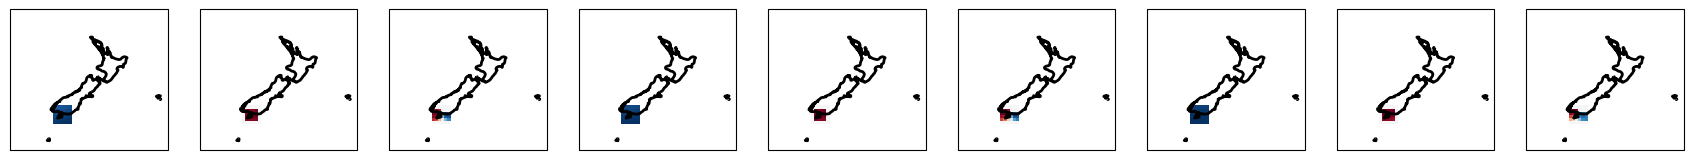

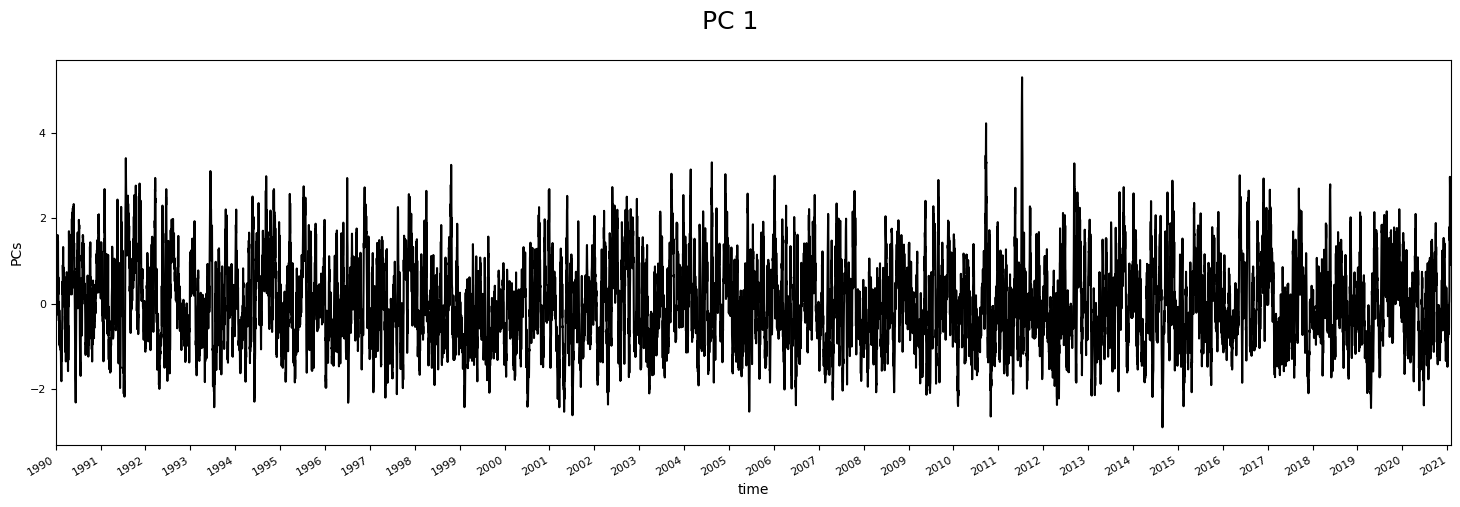


 ---------------------------------------------------------                     

 Experiment 1 in site 744, coords = (array(173.0604534), array(-41.05019325)) ......                     

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (1.5, 1.5))} 

                     

 and iteration with indexes = (0, 0, 0, 0, 0)                     

 ---------------------------------------------------------
 PCs will be calculated with {'calculate_gradient': True, 'time_lapse': 3, 'time_resample': '1D', 'region': (True, (171.56045340050377, 174.56045340050377, -42.550193246772764, -39.550193246772764))} 

/home/javitausia/Documentos/geocean-nz-ss/data/pcs/ ['local_1.5_1.5', '744', 'winds', 'gradients', '1D', 'tl3']
FILE /home/javitausia/Documentos/geocean-nz-ss/data/pcs/local_1.5_1.5_744_winds_gradients_1D_tl3.nc
PCs loaded from file

 plotting 1 components with 9 EOFs + PC... 


 being the EOFs the slp, the gradient, in step

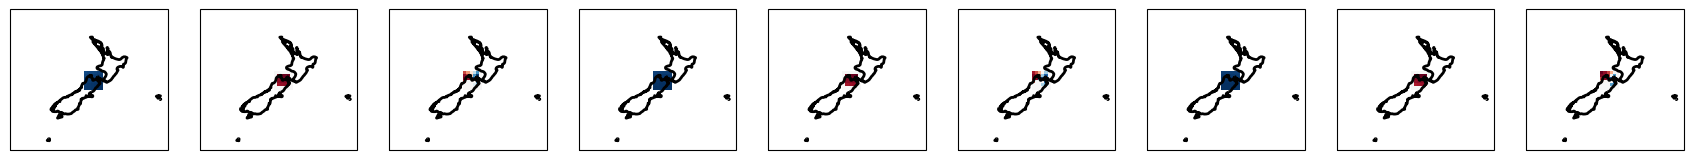

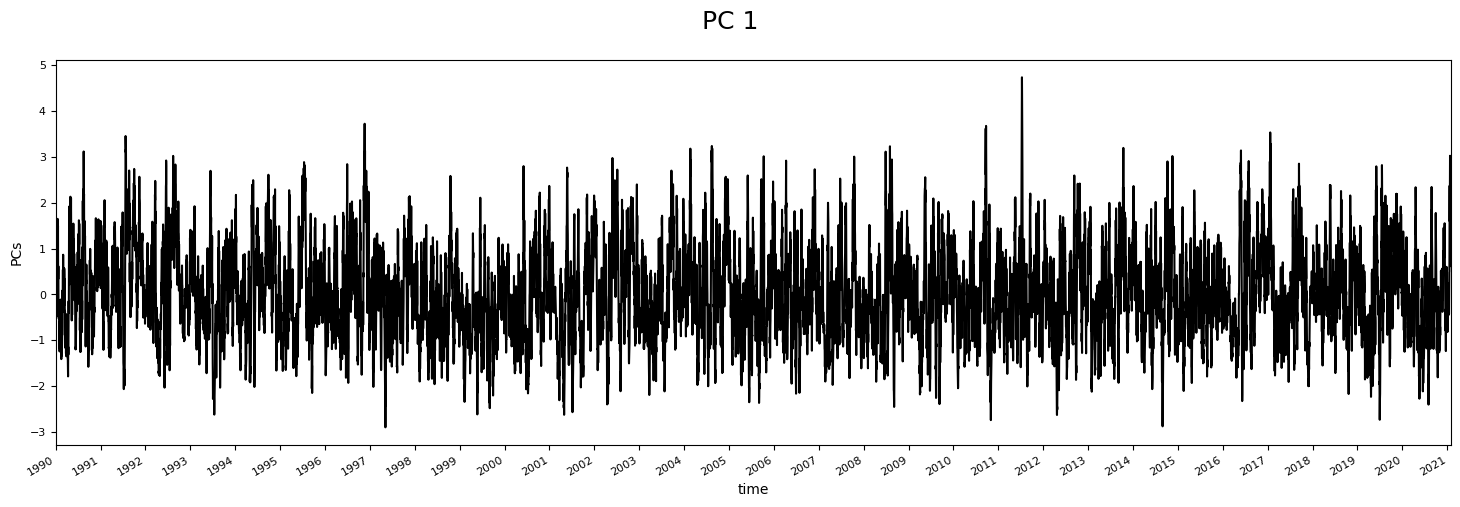


 ---------------------------------------------------------                     

 Experiment 1 in site 1217, coords = (array(174.81360202), array(-36.786094)) ......                     

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (1.5, 1.5))} 

                     

 and iteration with indexes = (0, 0, 0, 0, 0)                     

 ---------------------------------------------------------
 PCs will be calculated with {'calculate_gradient': True, 'time_lapse': 3, 'time_resample': '1D', 'region': (True, (173.31360201511333, 176.31360201511333, -38.28609400494574, -35.28609400494574))} 

/home/javitausia/Documentos/geocean-nz-ss/data/pcs/ ['local_1.5_1.5', '1217', 'winds', 'gradients', '1D', 'tl3']
FILE /home/javitausia/Documentos/geocean-nz-ss/data/pcs/local_1.5_1.5_1217_winds_gradients_1D_tl3.nc
PCs loaded from file

 plotting 1 components with 9 EOFs + PC... 


 being the EOFs the slp, the gradient, in step

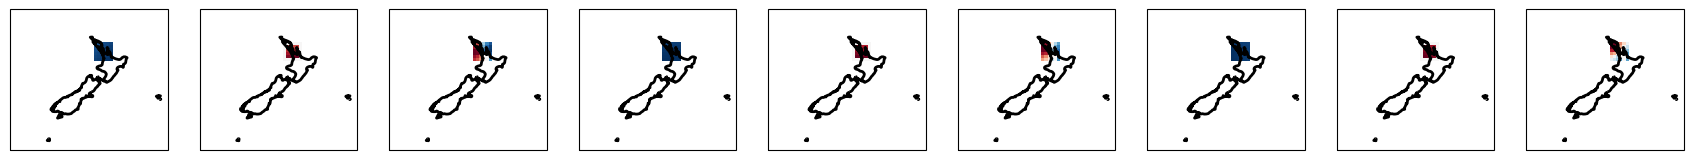

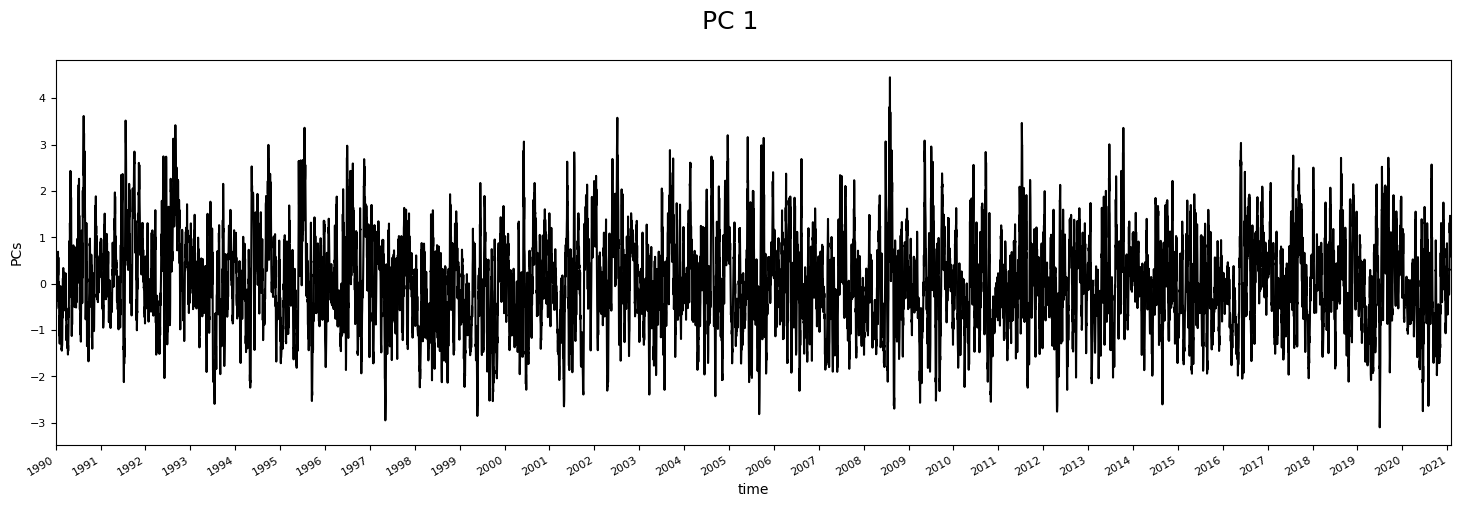

In [4]:
pca_attrs = {
    'calculate_gradient': [True, False],
    'winds': [True, False],
    'time_lapse': [1,2,3], # 1 equals to NO time delay 
    'time_resample': ['1D', '12H', '6H'], # 1D and 12H, 6H available...
    'region': [('local', (1.5, 1.5)), ('local',(2.5,2.5)), (True,default_region_reduced)]
}
pca_attrs = {
    'calculate_gradient': [True],
    'winds': [True],
    'time_lapse': [3], # 1 equals to NO time delay 
    'time_resample': ['1D'], # 1D and 12H, 6H available...
    'region': [('local', (1.5, 1.5))]
}

sites_to_analyze = np.unique( # closest Moana v2 Hindcast to tidal gauges
    [  689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
       1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
       1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
    ]   
)[::12]

PCA_precomputer = PCA_PreComputer(
    load_cfsr_moana_uhslc.predictor_slp,
    load_cfsr_moana_uhslc.predictor_wind,
    load_cfsr_moana_uhslc.predictand, # all the sites are passed to exp at first
    sites_to_analyze=sites_to_analyze, 
    pca_attrs=pca_attrs,
    pcs_folder='/home/javitausia/Documentos/geocean-nz-ss/data/pcs/'
)

PCA_precomputer.compute_pcas()

Now that the principal components are available on drive, we can release the memory occupied by the different data and objects used in the precomputing step.

In [5]:
del PCA_precomputer
# del load_cfsr_moana_uhslc

Unlike the PCA algorithms the regression experiments have a small memory footprint and run on a single core. Hence to maximise ressource usage we run multiple experiments in parallel. We parallelise the experiments run in a way that all predictor options for a single site are run in a separate process.

First we create a function that can run all perdictor and all algorithm configuration for a single site location.

In [8]:
def run_xgboost_experiment(site_num):
    
    import os, sys
    # append sscode to path
    sys.path.insert(0, '/home/javitausia/Documentos/geocean-nz-ss')
    data_path = '/data' #'/data/storm_surge_data/'
    os.environ["SSURGE_DATA_PATH"] = data_path
    
    from sscode.data import load_moana_hindcast
    from sscode.experiment_new import Experiment
    from sscode.config import default_region_reduced
    
    import xarray as xr
    import numpy as np
    import dill
    
    # experiment attributes
    # ---------------------
    # sites_to_analyze = [site_num]
    sites_to_analyze = site_num
    
    # Predictor configurations to iterate through
    pca_attrs_exp = {
        'calculate_gradient': [True],
        'winds': [True],
        'time_lapse': [2], # 1 equals to NO time delay 
        'time_resample': ['1D'], # 6H and 12H available...
        'region': [('local',(1.5,1.5))]
    }
    
    # Labels to use for the different predictor domains
    region_labels = ['local_1.5_1.5'] #,'local_2.5_2.5','default_region_reduced']
    
    # Configuration of the xgboost regression algorithm to iterate through
    xgboost_attrs_exp = {
        'train_size': [0.7], 'percentage_PCs': [0.98],
        'n_estimators': [50], 'max_depth': [12],
        'min_samples_split': [0.06],
        'learning_rate': [0.1], 'loss': ['ls'] # more could be added
    }
    
    # Loading predictand data
    # predictand = load_moana_hindcast(plot=False)
    
    # create the experiment
    experiment = Experiment(# None, # No need for pressure data we expect PCs to be already available
                            # None, # No need for wind data we expect PCs to be already available
                            load_cfsr_moana_uhslc.predictor_slp,
                            load_cfsr_moana_uhslc.predictor_wind,
                            load_cfsr_moana_uhslc.predictand, # all the sites are passed to exp at first
                            sites_to_analyze=sites_to_analyze, 
                            model='xgboost', # model that will be used to predict
                            pca_attrs=pca_attrs_exp,
                            model_attrs=xgboost_attrs_exp,
                            pcs_folder='/home/javitausia/Documentos/geocean-nz-ss/data/pcs/'
    )
    
    # Run experiment
    exp_parameters, exp_mean_parameters, stats_keys = \
        experiment.execute_cross_model_calculations(verbose=True,
                                                    plot=True # plot logs when computing the models
    )
    
    # Pack results
    coords_dict = {'grad': pca_attrs_exp['calculate_gradient'],
                   'winds': pca_attrs_exp['winds'],
                   'tlapse': pca_attrs_exp['time_lapse'],
                   'tresample': pca_attrs_exp['time_resample'],
                   'region': region_labels,
                   'tsize': xgboost_attrs_exp['train_size'],
                   'perpcs': xgboost_attrs_exp['percentage_PCs'],
                   'n_estimators': xgboost_attrs_exp['n_estimators'],
                   'max_depth': xgboost_attrs_exp['max_depth'],
                   'min_samples_split': xgboost_attrs_exp['min_samples_split'],
                   'learning_rate': xgboost_attrs_exp['learning_rate'],
                   'loss': xgboost_attrs_exp['loss']
                  }
    
    site_metrics = {}
    for im,metric in enumerate(stats_keys):
        site_metrics[metric] = (
            ('grad','winds','tlapse','tresample','region','tsize','perpcs',
             'n_estimators','max_depth','min_samples_split','learning_rate','loss'),
             exp_parameters[0][:,:,:,:,:,:,:,:,:,:,:,:,im])
    experiment_metrics = xr.Dataset(site_metrics).assign(coords_dict)\
        .expand_dims({'site':[experiment.ss_sites[0]]})
  
    # Return results as pickle object
    return experiment_metrics # dill.dumps(experiment_metrics)

Given a list of site ids we want to run all the experiments for, we create a pool of size 8 which will allow us to keep one job running on each of the 8 cores available on our server and run all the simulations.


 The model has been correctly initialized with || model = xgboost ||             

 and model evaluation metrics = ['bias', 'si', 'rmse', 'rel_rmse', 'ext_rmse', 'ext_rel_rmse', 'pearson', 'rscore', 'spearman', 'ext_pearson', 'ext_rscore', 'ext_spearman', 'pocid', 'tu_test', 'expl_var', 'nse', 'kge', 'kgeprime', 'ext_nse', 'ext_kge', 'ext_kgeprime']             

 pca_params = {'calculate_gradient': [True], 'winds': [True], 'time_lapse': [2], 'time_resample': ['1D'], 'region': [('local', (1.5, 1.5))]} 

 model_params = {'train_size': [0.7], 'percentage_PCs': [0.98], 'n_estimators': [50], 'max_depth': [12], 'min_samples_split': [0.06], 'learning_rate': [0.1], 'loss': ['ls']}             

 which makes a total of 1 iterations as there are (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1) values for each parameter             

 the experiment will be performed in sites = [ 116 1146]             

 RUN CELL BELOW if this information is correct!!

 -----------------------------------------------------

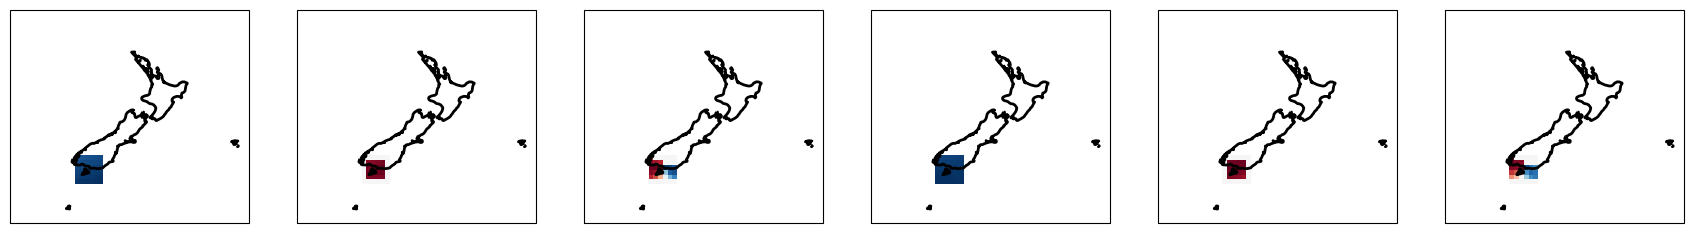

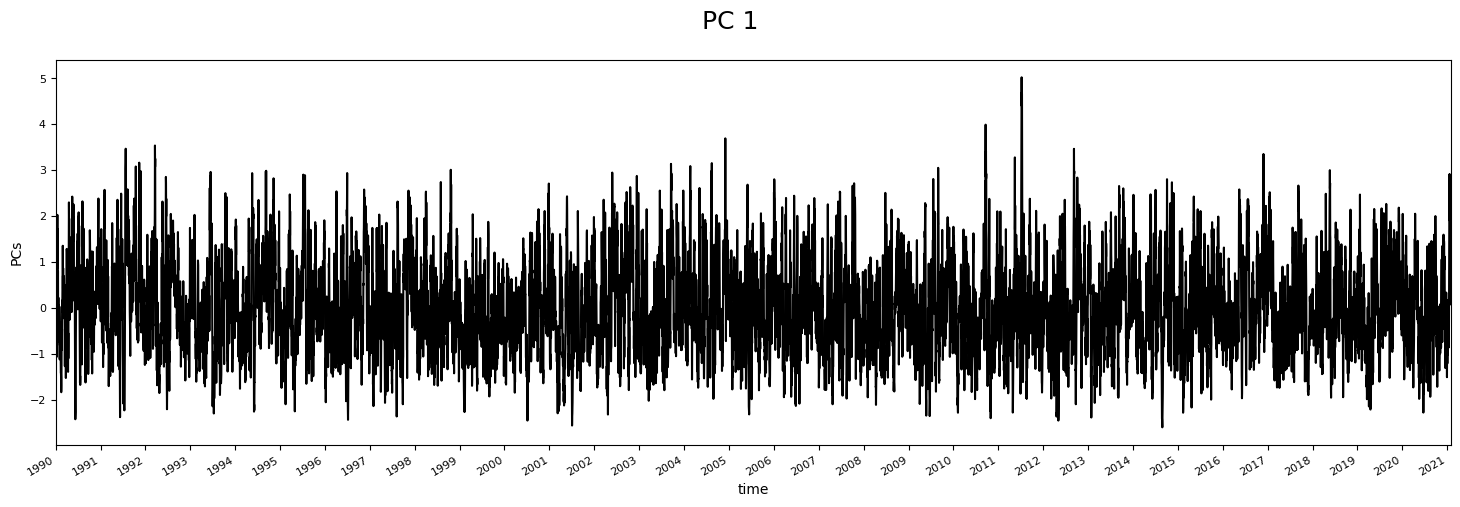


 8 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.06, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 



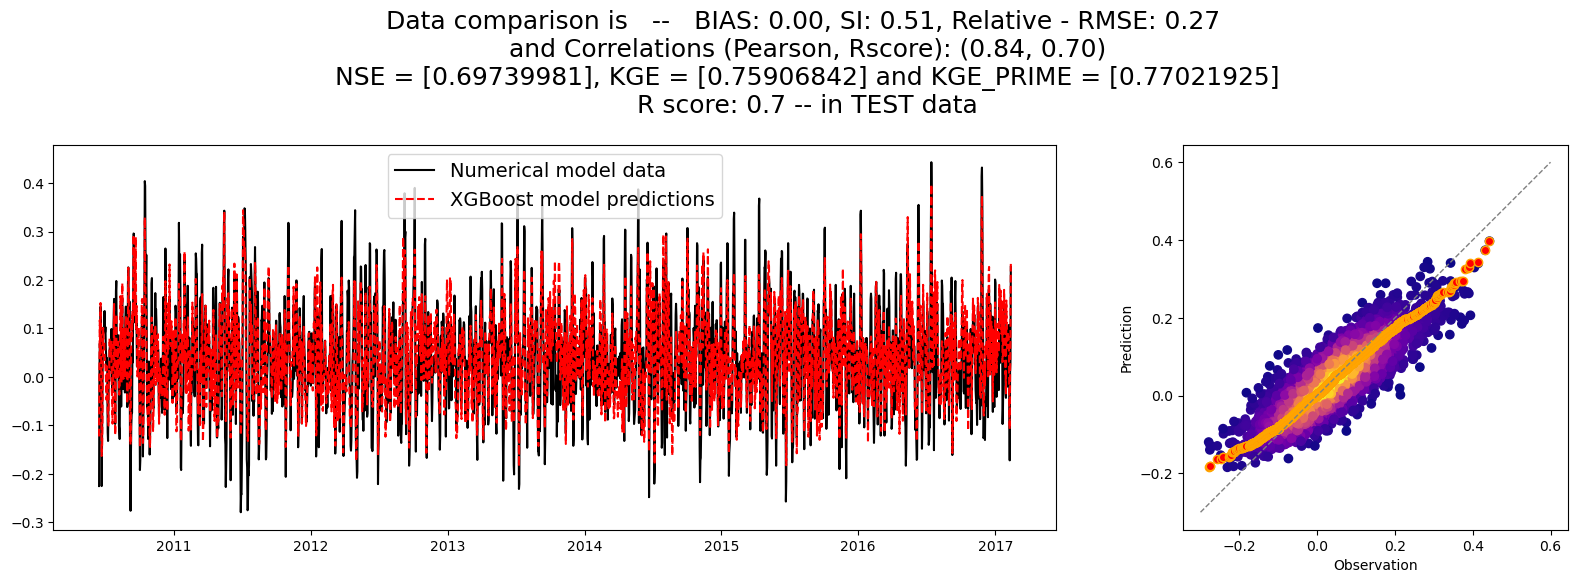

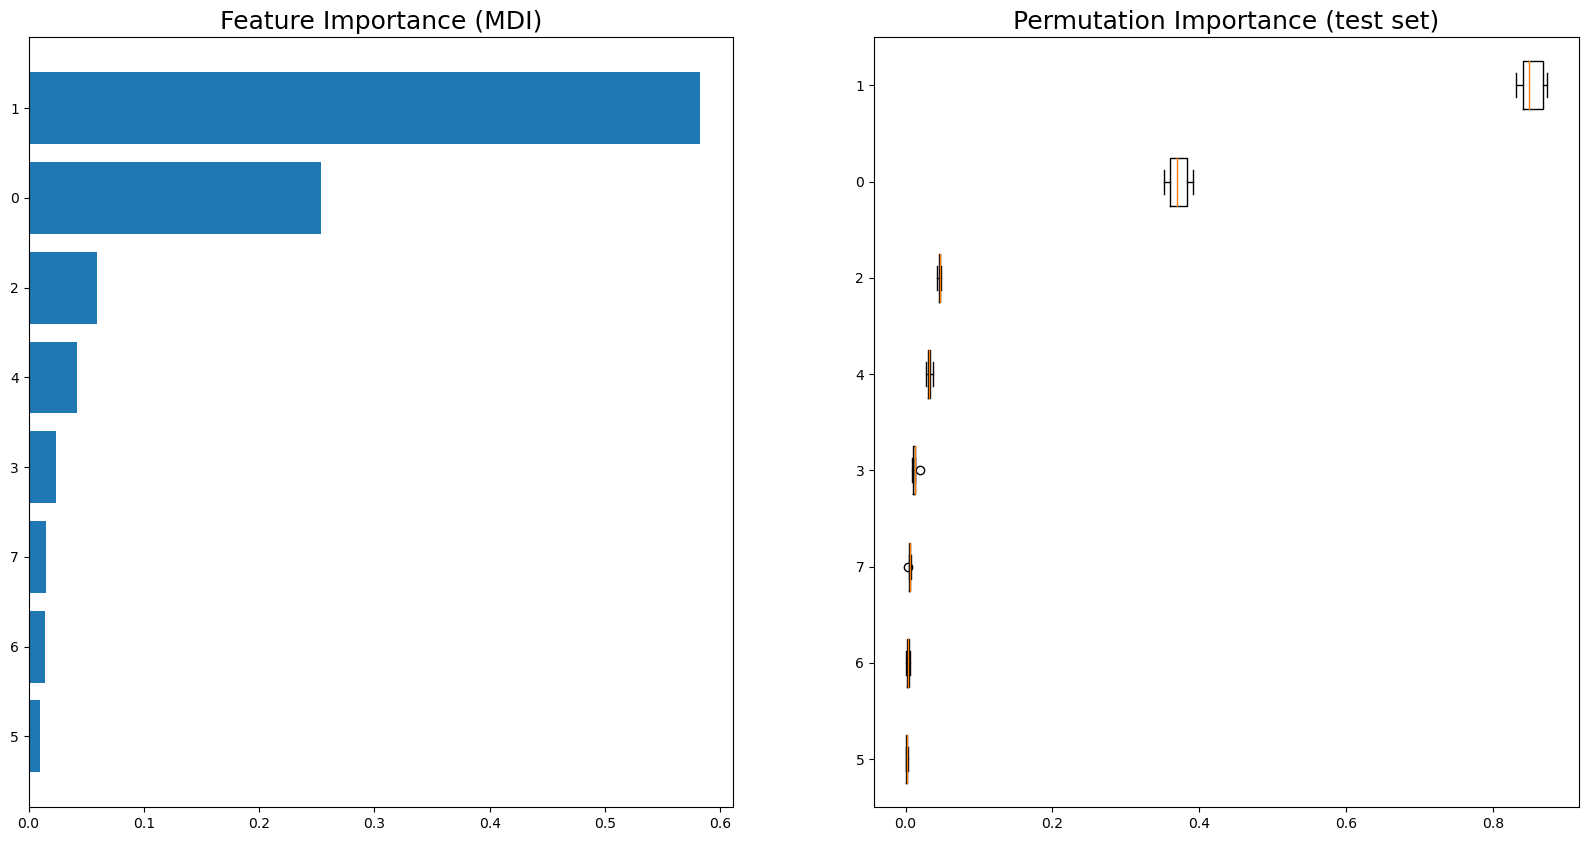

Data comparison is   --   BIAS: 0.00, SI: 0.51, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.69739981], KGE = [0.75906842] and KGE_PRIME = [0.77021925]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 1 in site 1146 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 2, 'time_resample': '1D', 'region': ('local', (1.5, 1.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.06, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)                         

/home/javitausia/Documentos/geocean-nz-ss/data/pcs/ ['local_1.5_1.5', '1146', 'winds', 'gradients', '1D', 'tl2']
FILE /home/javitausia/Documentos/geocean-nz-ss/data/pcs/local_1.5_1.5_1146_winds_gradients_1D_tl2.nc
PCs l

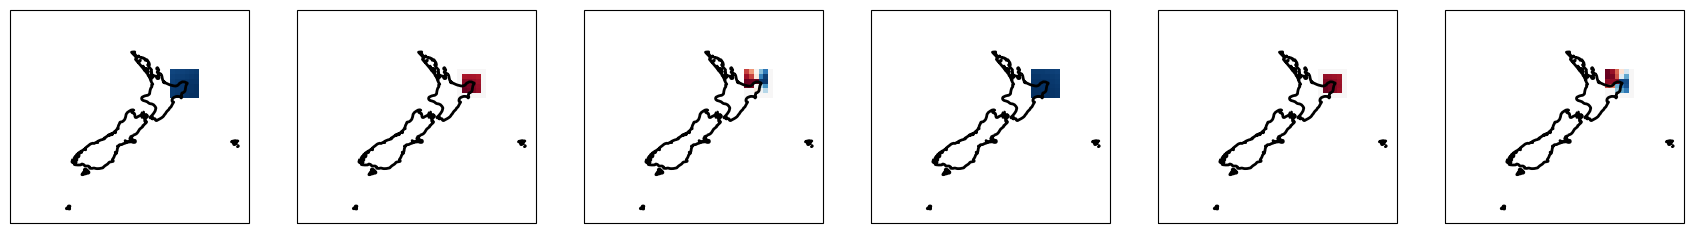

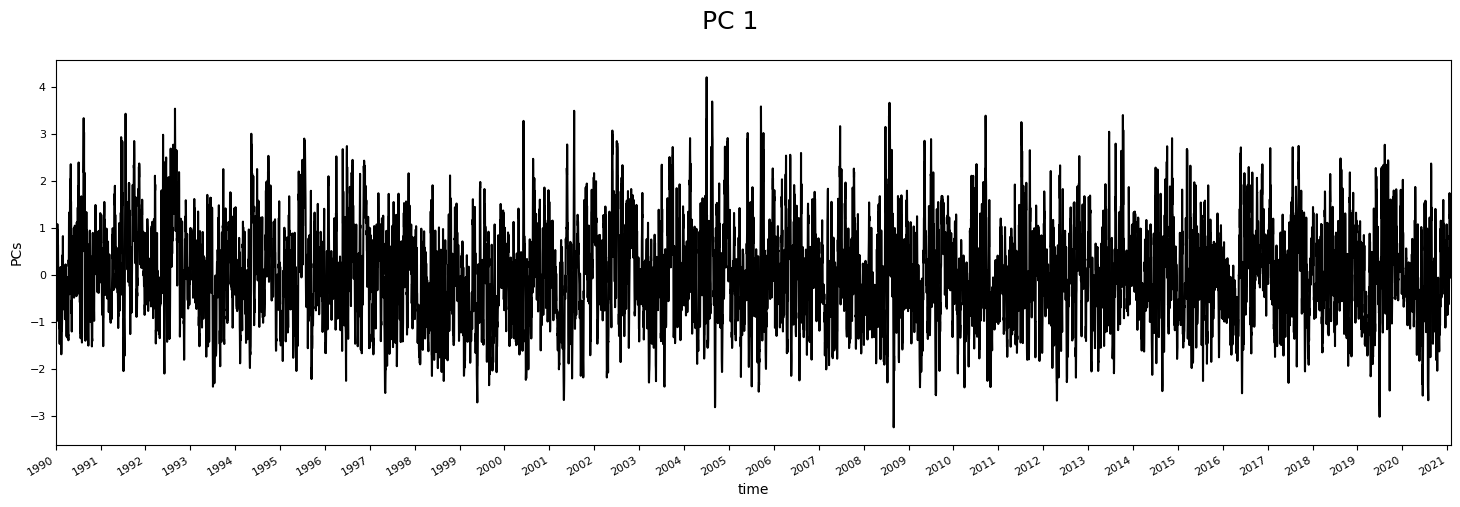


 9 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.06, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 



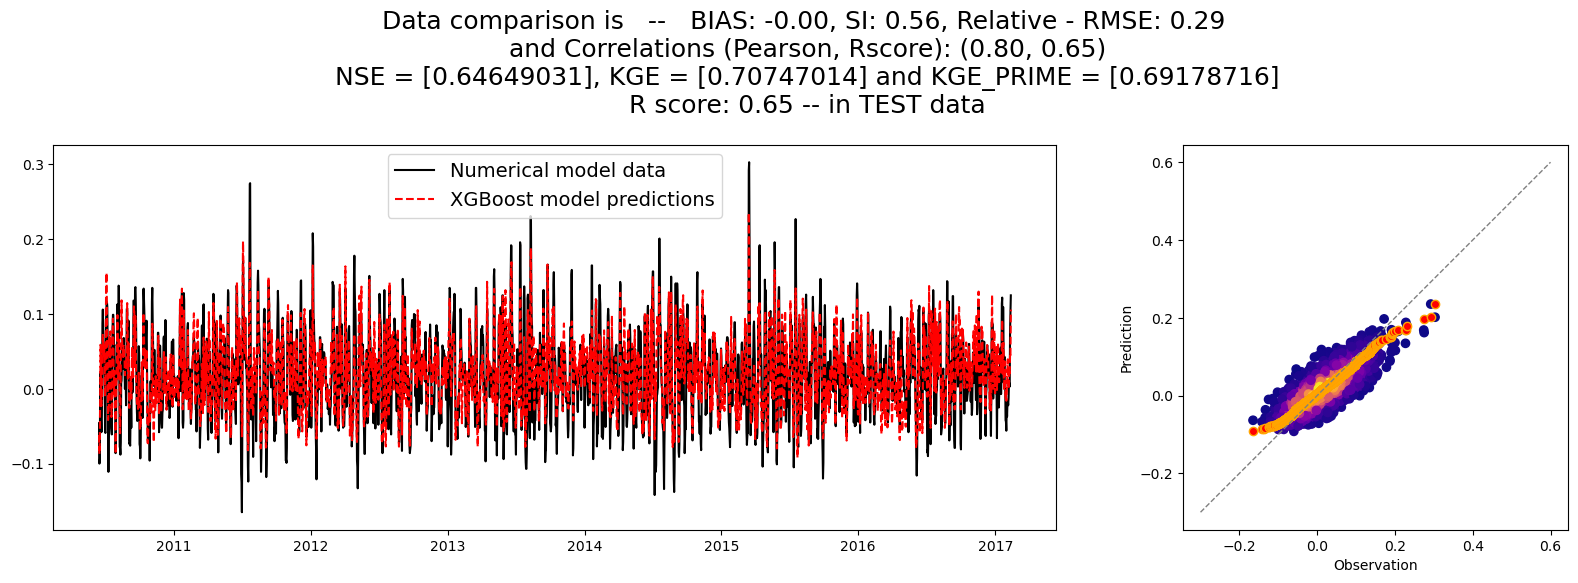

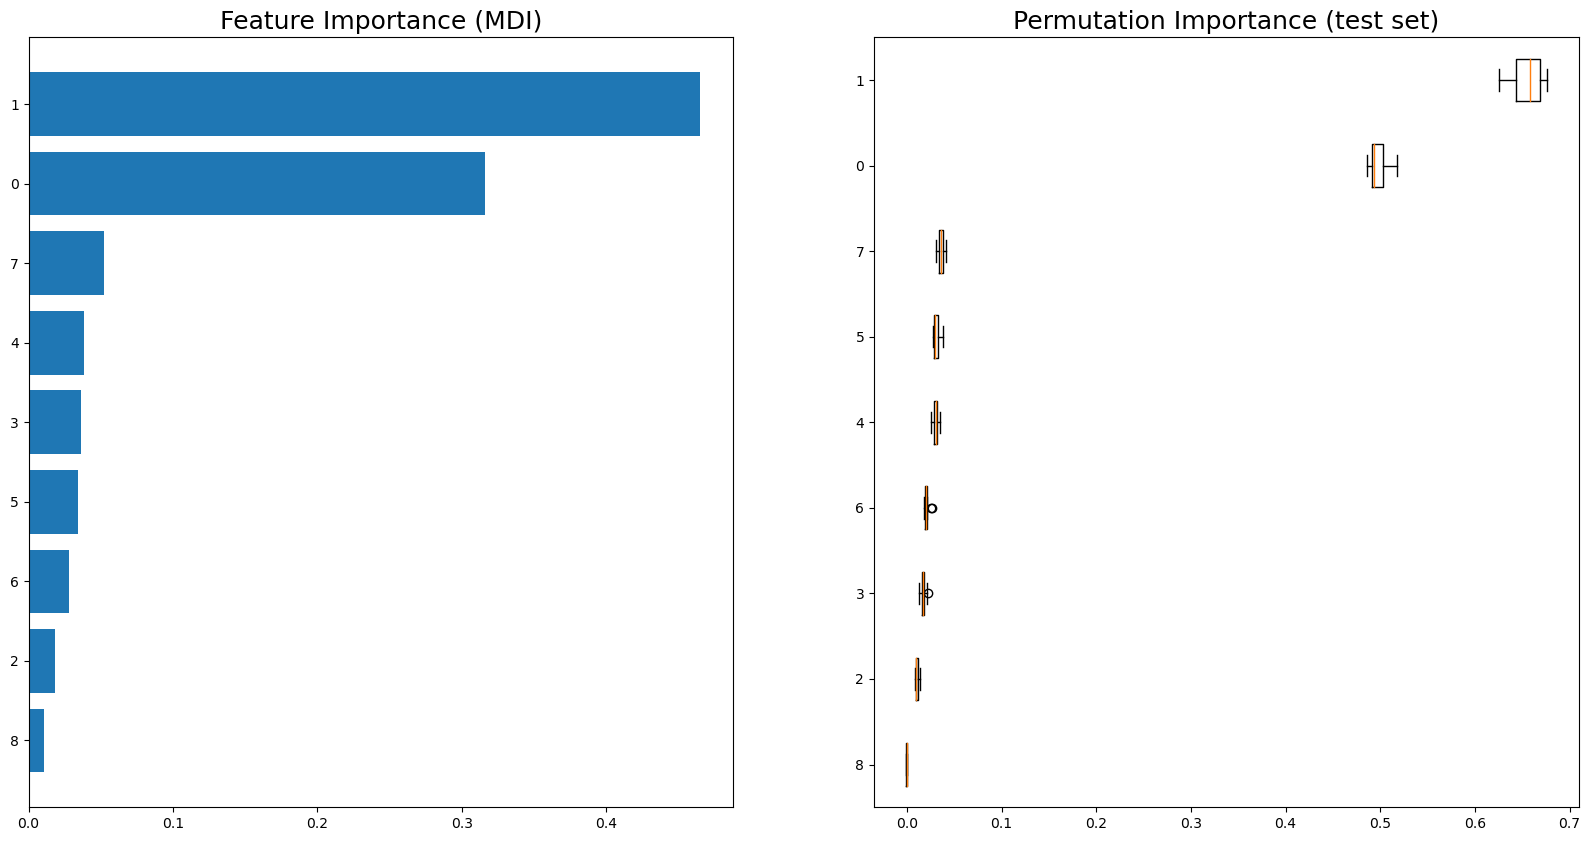

Data comparison is   --   BIAS: -0.00, SI: 0.56, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.80, 0.65)
 NSE = [0.64649031], KGE = [0.70747014] and KGE_PRIME = [0.69178716]
 R score: 0.65 -- in TEST data

 -------------------------------------------------------------------             

 All the models and in all the sites have been correctly calculated!!             

 with a final mean stats (in the sites) with the following shape...             

 BIAS, SI, RMSE, Pearson and Spearman coorelations and the R2 score... 

 [[[[[[[[[[[[[ 1.35461179e-04  5.38026413e-01  4.78203367e-02
              2.77323693e-01  6.89292866e-02  7.56935751e-02
              9.60243810e-02  2.53273530e-01  2.45913507e-01
              2.63851664e-01  8.19772178e-01  6.71945059e-01
              8.07895207e-01  5.95997939e-01  5.71397456e-01
              6.04347513e-01 -1.28504529e+00 -2.30033611e+00
             -9.37377186e+00  5.06984420e-01  4.70757644e-01
              4.51772909e-01

In [9]:
sites_to_analyze = np.unique( # closest Moana v2 Hindcast to tidal gauges
    [ 689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
      1296,378,1124,780,613,488,1442,1217,578,  200,1177,1025,689,949,224,1146, # LINZ
      1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
    ]
)[::20]
    
# with Pool(8) as p:
#     all_results = p.map(run_xgboost_experiment, sites_to_analyze)

all_results = run_xgboost_experiment(sites_to_analyze)

Once all the experiments are run, the results can be put together into an xarray dataset and stored to drive.

In [ ]:
# xgboost_results = xr.concat([dill.loads(r) for r in all_results], dim='site')
# xgboost_results.to_netcdf('xgboost_results.nc')

We repeat the operation for the multilinear regression.

In [ ]:
def run_linear_experiment(site_num):
    
    import os, sys
    # append sscode to path
    sys.path.insert(0, '/home/javitausia/Documentos/geocean-nz-ss')
    data_path = '/data' #'/data/storm_surge_data/'
    os.environ["SSURGE_DATA_PATH"] = data_path
    
    from sscode.data import load_moana_hindcast
    from sscode.experiment_new import Experiment
    from sscode.config import default_region_reduced
    
    import xarray as xr
    import numpy as np
    import dill
    
    # experiment attributes
    # ---------------------
    # sites_to_analyze = [site_num]
    sites_to_analyze = site_num
    
    # Predictor configurations to iterate through
    pca_attrs_exp = {
        'calculate_gradient': [True],
        'winds': [True],
        'time_lapse': [2], # 1 equals to NO time delay 
        'time_resample': ['1D'], # 6H and 12H available...
        'region': [('local',(1.5,1.5))]
    }
    
    # Labels to use for the different predictor domains
    region_labels = ['local_1.5_1.5','local_2.5_2.5','default_region_reduced']
    
    # Configuration of the linear regression algorithm to iterate through
    linear_attrs_exp = {
        'train_size': [0.7], 'percentage_PCs': [0.98]
    }
    
    # Loading predictand data
    predictand = load_moana_hindcast(plot=False)
    
    # Create the experiment
    experiment = Experiment(# None, # No need for pressure data we expect PCs to be already available
                            # None, # No need for wind data we expect PCs to be already available
                            load_cfsr_moana_uhslc.predictor_slp,
                            load_cfsr_moana_uhslc.predictor_wind,
                            load_cfsr_moana_uhslc.predictand, # all the sites are passed to exp at first
                            sites_to_analyze=sites_to_analyze, 
                            model='linear', # model that will be used to predict
                            pca_attrs=pca_attrs_exp,
                            model_attrs=linear_attrs_exp,
                            pcs_folder='/home/javitausia/Documentos/geocean-nz-ss/data/pcs/'
    )
    
    # Run the experiment
    exp_parameters, exp_mean_parameters, stats_keys =\
        experiment.execute_cross_model_calculations(verbose=False,
                                                    plot=False # plot logs when computing the models
    )
    
    coords_dict = {'grad': pca_attrs_exp['calculate_gradient'],
                   'winds': pca_attrs_exp['winds'],
                   'tlapse': pca_attrs_exp['time_lapse'],
                   'tresample': pca_attrs_exp['time_resample'],
                   'region': region_labels,
                   'tsize': linear_attrs_exp['train_size'],
                   'perpcs': linear_attrs_exp['percentage_PCs']}
    
    site_metrics = {}
    for im,metric in enumerate(stats_keys):
        site_metrics[metric] = (
            ('grad','winds','tlapse','tresample','region','tsize','perpcs'),
             exp_parameters[0][:,:,:,:,:,:,:,im])
    experiment_metrics = xr.Dataset(site_metrics).assign(coords_dict)\
        .expand_dims({'site':[experiment.ss_sites[0]]})
    
    return dill.dumps(experiment_metrics)

In [ ]:
with Pool(8) as p:
    all_results = p.map(run_linear_experiment, sites_to_analyze)

In [ ]:
linear_results = xr.concat([dill.loads(r) for r in all_results],
                            dim='site')
linear_results.to_netcdf('linear_results.nc')

And finally we run the knn experiments. This time we choose to run one process per number of neignour value instead of per site.

In [ ]:
def run_knn_experiment(k_neighbors):
    
    import os, sys
    # append sscode to path
    sys.path.insert(0, '/home/metocean/geocean-nz-ss')
    data_path = '/data' #'/data/storm_surge_data/'
    os.environ["SSURGE_DATA_PATH"] = data_path
    
    from sscode.data import load_moana_hindcast
    from sscode.experiment_new import Experiment
    # custom
    from sscode.config import default_region_reduced
    
    import xarray as xr
    import numpy as np
    import dill
    
    # experiment attributes
    # ---------------------
    
    # sites to iterated through
    sites_to_analyze = np.unique( # closest Moana v2 Hindcast to tidal gauges
        [ 689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
          1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
          1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
        ]
    )

    # Predictor configurations to iterate through
    pca_attrs_exp = {
        'calculate_gradient': [False,True],
        'winds': [False,True],
        'time_lapse': [1,2,3], # 1 equals to NO time delay 
        'time_resample': ['6H','12H','1D'], # 6H and 12H available...
        'region': [('local',(1.5,1.5)),('local',(2.5,2.5)),(True,default_region_reduced)]
    }
    
    # Labels to use for the different predictor domains
    region_labels = ['local_1.5_1.5', 'local_2.5_2.5', 'default_region_reduced']
    
    # Configuration of the knn regression algorithm to iterate through
    knn_attrs_exp = {
        'train_size': [0.7],
        'percentage_PCs': [0.98],
        'k_neighbors': [None if k_neighbors == 0 else k_neighbors] # None calculates the optimum k-neighs
    }
    
    predictand = load_moana_hindcast(plot=False)
    
    # create the experiment
    experiment = Experiment(None,
                            None,
                            predictand, # all the sites are passed to exp at first
                            sites_to_analyze=sites_to_analyze, 
                            model='knn', # model that will be used to predict
                            pca_attrs=pca_attrs_exp,
                            model_attrs=knn_attrs_exp,
                            pcs_folder='/home/metocean/pcs/')
    
    # Run the experiment
    exp_parameters, exp_mean_parameters, stats_keys =\
        experiment.execute_cross_model_calculations(verbose=True,
                                                    plot=False # plot logs when computing the models
                                                   )
    # Pack results
    coords_dict = {'site': experiment.ss_sites,
                   'grad': pca_attrs_exp['calculate_gradient'],
                   'winds': pca_attrs_exp['winds'],
                   'tlapse': pca_attrs_exp['time_lapse'],
                   'tresample': pca_attrs_exp['time_resample'],
                   'region': region_labels,
                   'tsize': knn_attrs_exp['train_size'],
                   'perpcs': knn_attrs_exp['percentage_PCs'],
                   'k_neighbors': [k_neighbors]}
    
    site_metrics = {}
    for im,metric in enumerate(stats_keys):
        site_metrics[metric] = (
            ('site', 'grad','winds','tlapse','tresample','region','tsize','perpcs','k_neighbors'),
            np.concatenate([np.expand_dims(exp_param[:,:,:,:,:,:,:,:,im],0)
                             for exp_param in exp_parameters], 0))
    experiment_metrics = xr.Dataset(site_metrics).assign(coords_dict)

    return dill.dumps(experiment_metrics)

Run the knn experiments for number of neibours ranging from 0 to 51

In [ ]:
with Pool(8) as p:
    all_results = p.map(run_knn_experiment, range(0, 51))

In [ ]:
knn_results = xr.concat([dill.loads(r) for r in all_results],
                         dim='k_neighbors')
knn_results.to_netcdf('knn_results.nc')